# Multi-file Kerchunk Dataset for SalishSeaCast netCDF Results

Scan a collection of SalishSeaCast netCDF files to create a collection of Kerchunk reference files.
Then combine those references to create a combine reference for a virtual dataset for the collection.
Finally,
demonstrate access to an arbitrary slice in the collection.
This notebook is guided by the Multi-File Datasets with Kerchunk notebook in Project Pythia Kerchunk Cookbook.

ref: https://zenodo.org/badge/latestdoi/588661659

In [1]:
import os
from pathlib import Path

import arrow
import fsspec
import kerchunk.combine
import kerchunk.hdf
import ujson
import xarray

Generate a list of netCDF file paths to create Kerchunk references for:

In [2]:
results_archive = Path("/results2/SalishSea/nowcast-green.202111/")

start_date, end_date = arrow.get("2007-01-01"), arrow.get("2007-01-02")

nc_paths = []
for day in arrow.Arrow.range("day", start_date, end_date):
    ddmmmyy = day.format("DDMMMYY").lower()
    yyyymmdd = day.format("YYYYMMDD")
    nc_paths.append(results_archive / ddmmmyy / f"SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc")

nc_paths

[PosixPath('/results2/SalishSea/nowcast-green.202111/01jan07/SalishSea_1h_20070101_20070101_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/02jan07/SalishSea_1h_20070102_20070102_grid_T.nc')]

Function to generate Kerchunk reference .json file for a specified netCDF file and store the
reference file is a specified directory with the same file name stem as the netCDF file:

In [3]:
def generate_json_reference(nc_path, refs_dir):
    with fsspec.open(nc_path) as nc_file:
        h5chunks = kerchunk.hdf.SingleHdf5ToZarr(nc_file, os.fspath(nc_path))
        ref_file_name = f"{nc_path.stem}.json"
        with (refs_dir / ref_file_name).open("wb") as ref_file:
            ref_file.write(ujson.dumps(h5chunks.translate()).encode())
        return ref_file_name

Create the directory where the reference files will be stored:

In [4]:
refs_dir = Path("references")
refs_dir.mkdir(exist_ok=True)

refs_dir

PosixPath('references')

Generate the per-netCDF file reference files:

In [5]:
ref_files = []
for nc_path in nc_paths:
    ref_file = generate_json_reference(nc_path, refs_dir)
    ref_files.append(refs_dir / ref_file)

ref_files

[PosixPath('references/SalishSea_1h_20070101_20070101_grid_T.json'),
 PosixPath('references/SalishSea_1h_20070102_20070102_grid_T.json')]

Combine the per-netCDF file reference files into a reference file for the whole dataset:

In [24]:
mzz = kerchunk.combine.MultiZarrToZarr(
    [os.fspath(ref_file) for ref_file in ref_files],
    concat_dims=["time_counter"],
    identical_dims=["y", "x", "nvertex", "deptht", "axis_nbounds"],
)
with open("combined_kerchunk.json", "wb") as f:
    f.write(ujson.dumps(mzz.translate()).encode())

Open the dataset in `xarray` useing the `kerchunk` engine:

In [25]:
%%time
ds = xarray.open_dataset(
    "combined_kerchunk.json",
    engine="kerchunk",
    open_dataset_options={
        "chunks": {},
    },
)

ds

CPU times: user 35.8 ms, sys: 0 ns, total: 35.8 ms
Wall time: 33.1 ms


<xarray.Dataset> Size: 12GB
Dimensions:               (time_counter: 48, y: 898, x: 398, nvertex: 4,
                           deptht: 40, axis_nbounds: 2)
Coordinates:
  * deptht                (deptht) float32 160B 0.5 1.5 2.5 ... 414.5 441.5
    nav_lat               (time_counter, y, x) float32 69MB ...
    nav_lon               (time_counter, y, x) float32 69MB ...
    time_centered         (time_counter) datetime64[ns] 384B ...
  * time_counter          (time_counter) datetime64[ns] 384B 2007-01-01T00:30...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area                  (time_counter, y, x) float32 69MB ...
    bounds_lat            (time_counter, y, x, nvertex) float32 274MB ...
    bounds_lon            (time_counter, y, x, nvertex) float32 274MB ...
    deptht_bounds         (time_counter, deptht, axis_nbounds) float32 15kB ...
    e3t                   (time_counter, deptht, y, x) float32 3GB ...
    sigma_theta           (time_counter, deptht, y, x) float32 3GB ...
    sossheig              (time_counter, y, x) float32 69MB ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 768B ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 768B ...
    vosaline              (time_counter, deptht, y, x) float32 3GB ...
    votemper              (time_counter, deptht, y, x) float32 3GB ...
Attributes:
    Conventions:  CF-1.6
    description:  physics tracers and VVL layer thicknesses
    name:         SalishSea_1h_20070101_20070105
    timeStamp:    2022-Oct-24 21:24:51 GMT
    title:        physics tracers and VVL layer thicknesses
    uuid:         4a8ebbb4-f129-4b42-bcde-4004b6cb9b4a

Plot an arbitrary density surface:

CPU times: user 1.03 s, sys: 196 ms, total: 1.23 s
Wall time: 1.7 s


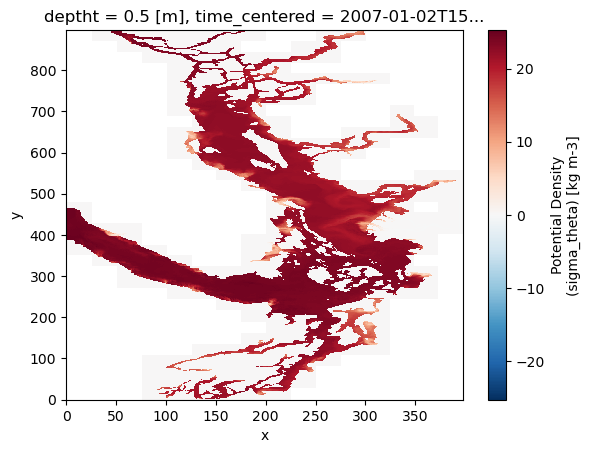

In [8]:
%%time
ds.sigma_theta.sel(time_counter="2007-01-02 15:30:00").sel(deptht=0.5, method="nearest").plot()

Plot another arbitrary density surface.

Note that there is little difference in time even though the surfaces are from different netCDF files.
Also,
the order of the netCDF files in the list that we generate the per-netCDF references from does not
affect the access file (test not shown).

CPU times: user 258 ms, sys: 48.3 ms, total: 307 ms
Wall time: 304 ms


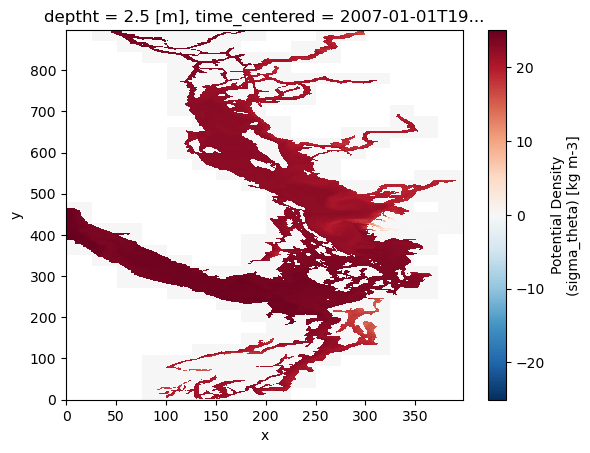

In [9]:
%%time
ds.sigma_theta.sel(time_counter="2007-01-01 19:30:00").sel(deptht=3, method="nearest").plot()

## Can we combine different variable groups on the T-grid in the Kerchunk reference?

e.g. physics (`*_grid_T.nc`) and chemistry (`*_chem_T.nc`)

In [10]:
results_archive = Path("/results2/SalishSea/nowcast-green.202111/")

start_date, end_date = arrow.get("2007-01-01"), arrow.get("2007-01-02")

nc_paths = []
for day in arrow.Arrow.range("day", start_date, end_date):
    ddmmmyy = day.format("DDMMMYY").lower()
    yyyymmdd = day.format("YYYYMMDD")
    nc_paths.append(results_archive / ddmmmyy / f"SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc")
    nc_paths.append(results_archive / ddmmmyy / f"SalishSea_1h_{yyyymmdd}_{yyyymmdd}_chem_T.nc")

nc_paths

[PosixPath('/results2/SalishSea/nowcast-green.202111/01jan07/SalishSea_1h_20070101_20070101_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/01jan07/SalishSea_1h_20070101_20070101_chem_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/02jan07/SalishSea_1h_20070102_20070102_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/02jan07/SalishSea_1h_20070102_20070102_chem_T.nc')]

In [11]:
ref_files = []
for nc_path in nc_paths:
    ref_file = generate_json_reference(nc_path, refs_dir)
    ref_files.append(refs_dir / ref_file)

ref_files

[PosixPath('references/SalishSea_1h_20070101_20070101_grid_T.json'),
 PosixPath('references/SalishSea_1h_20070101_20070101_chem_T.json'),
 PosixPath('references/SalishSea_1h_20070102_20070102_grid_T.json'),
 PosixPath('references/SalishSea_1h_20070102_20070102_chem_T.json')]

In [12]:
mzz = kerchunk.combine.MultiZarrToZarr(
    [os.fspath(ref_file) for ref_file in ref_files],
    concat_dims=["time_counter"],
    identical_dims=["y", "x", "nvertex", "deptht", "axis_nbounds"]
)
with open("combined_kerchunk.json", "wb") as f:
    f.write(ujson.dumps(mzz.translate()).encode())

In [13]:
%%time
ds = xarray.open_dataset(
    "combined_kerchunk.json",
    engine="kerchunk",
    open_dataset_options={"chunks": {}},
)

ds

CPU times: user 29 ms, sys: 541 µs, total: 29.5 ms
Wall time: 26.9 ms


<xarray.Dataset> Size: 12GB
Dimensions:               (time_counter: 48, y: 898, x: 398, nvertex: 4,
                           deptht: 40, axis_nbounds: 2)
Coordinates:
  * deptht                (deptht) float32 160B 0.5 1.5 2.5 ... 414.5 441.5
    nav_lat               (time_counter, y, x) float32 69MB ...
    nav_lon               (time_counter, y, x) float32 69MB ...
    time_centered         (time_counter) datetime64[ns] 384B ...
  * time_counter          (time_counter) datetime64[ns] 384B 2007-01-01T00:30...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area                  (time_counter, y, x) float32 69MB ...
    bounds_lat            (time_counter, y, x, nvertex) float32 274MB ...
    bounds_lon            (time_counter, y, x, nvertex) float32 274MB ...
    deptht_bounds         (time_counter, deptht, axis_nbounds) float32 15kB ...
    e3t                   (time_counter, deptht, y, x) float32 3GB ...
    sigma_theta           (time_counter, deptht, y, x) float32 3GB ...
    sossheig              (time_counter, y, x) float32 69MB ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 768B ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 768B ...
    vosaline              (time_counter, deptht, y, x) float32 3GB ...
    votemper              (time_counter, deptht, y, x) float32 3GB ...
Attributes:
    Conventions:  CF-1.6
    description:  physics tracers and VVL layer thicknesses
    name:         SalishSea_1h_20070101_20070105
    timeStamp:    2022-Oct-24 21:24:51 GMT
    title:        physics tracers and VVL layer thicknesses
    uuid:         4a8ebbb4-f129-4b42-bcde-4004b6cb9b4a

The naive approach failed...

Try kerchunk-ing physic and chemistry files separately,
then merging their references:

In [14]:
def calc_nc_paths(results_archive, grid, start_date, end_date):
    nc_paths = []
    for day in arrow.Arrow.range("day", start_date, end_date):
        ddmmmyy = day.format("DDMMMYY").lower()
        yyyymmdd = day.format("YYYYMMDD")
        nc_paths.append(results_archive / ddmmmyy / f"SalishSea_1h_{yyyymmdd}_{yyyymmdd}_{grid}.nc")
    return nc_paths

In [15]:
results_archive = Path("/results2/SalishSea/nowcast-green.202111/")

start_date, end_date = arrow.get("2007-01-01"), arrow.get("2007-01-02")



In [16]:
nc_paths = calc_nc_paths(results_archive, "grid_T", start_date, end_date)

nc_paths

[PosixPath('/results2/SalishSea/nowcast-green.202111/01jan07/SalishSea_1h_20070101_20070101_grid_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/02jan07/SalishSea_1h_20070102_20070102_grid_T.nc')]

In [17]:
ref_files = []
for nc_path in nc_paths:
    ref_file = generate_json_reference(nc_path, refs_dir)
    ref_files.append(refs_dir / ref_file)

ref_files

[PosixPath('references/SalishSea_1h_20070101_20070101_grid_T.json'),
 PosixPath('references/SalishSea_1h_20070102_20070102_grid_T.json')]

In [18]:
mzz = kerchunk.combine.MultiZarrToZarr(
    [os.fspath(ref_file) for ref_file in ref_files],
    concat_dims=["time_counter"],
    identical_dims=["y", "x", "nvertex", "deptht", "axis_nbounds"]
)
with open("physics_kerchunk.json", "wb") as f:
    f.write(ujson.dumps(mzz.translate()).encode())

In [19]:
nc_paths = calc_nc_paths(results_archive, "chem_T", start_date, end_date)

nc_paths

[PosixPath('/results2/SalishSea/nowcast-green.202111/01jan07/SalishSea_1h_20070101_20070101_chem_T.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/02jan07/SalishSea_1h_20070102_20070102_chem_T.nc')]

In [20]:
ref_files = []
for nc_path in nc_paths:
    ref_file = generate_json_reference(nc_path, refs_dir)
    ref_files.append(refs_dir / ref_file)

ref_files

[PosixPath('references/SalishSea_1h_20070101_20070101_chem_T.json'),
 PosixPath('references/SalishSea_1h_20070102_20070102_chem_T.json')]

In [21]:
mzz = kerchunk.combine.MultiZarrToZarr(
    [os.fspath(ref_file) for ref_file in ref_files],
    concat_dims=["time_counter"],
    identical_dims=["y", "x", "nvertex", "deptht", "axis_nbounds"]
)
with open("chemistry_kerchunk.json", "wb") as f:
    f.write(ujson.dumps(mzz.translate()).encode())

In [22]:
merged_ref = kerchunk.combine.merge_vars(
    ["physics_kerchunk.json", "chemistry_kerchunk.json"]
)
with open("combined_kerchunk.json", "wb") as f:
    f.write(ujson.dumps(merged_ref).encode())

In [23]:
%%time
ds2 = xarray.open_dataset(
    "combined_kerchunk.json",
    engine="kerchunk",
    open_dataset_options={"chunks": {}},
)

ds2

CPU times: user 29.6 ms, sys: 153 µs, total: 29.7 ms
Wall time: 28.7 ms


<xarray.Dataset> Size: 12GB
Dimensions:               (time_counter: 48, y: 898, x: 398, nvertex: 4,
                           deptht: 40, axis_nbounds: 2)
Coordinates:
  * deptht                (deptht) float32 160B 0.5 1.5 2.5 ... 414.5 441.5
    nav_lat               (time_counter, y, x) float32 69MB ...
    nav_lon               (time_counter, y, x) float32 69MB ...
    time_centered         (time_counter) datetime64[ns] 384B ...
  * time_counter          (time_counter) datetime64[ns] 384B 2007-01-01T00:30...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area                  (time_counter, y, x) float32 69MB ...
    bounds_lat            (time_counter, y, x, nvertex) float32 274MB ...
    bounds_lon            (time_counter, y, x, nvertex) float32 274MB ...
    deptht_bounds         (time_counter, deptht, axis_nbounds) float32 15kB ...
    e3t                   (time_counter, deptht, y, x) float32 3GB ...
    sigma_theta           (time_counter, deptht, y, x) float32 3GB ...
    sossheig              (time_counter, y, x) float32 69MB ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 768B ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 768B ...
    vosaline              (time_counter, deptht, y, x) float32 3GB ...
    votemper              (time_counter, deptht, y, x) float32 3GB ...
Attributes:
    Conventions:  CF-1.6
    description:  physics tracers and VVL layer thicknesses
    name:         SalishSea_1h_20070101_20070105
    timeStamp:    2022-Oct-24 21:24:51 GMT
    title:        physics tracers and VVL layer thicknesses
    uuid:         4a8ebbb4-f129-4b42-bcde-4004b6cb9b4a

It's not clear to me why this doesn't work.
`combined_kerchunk.json` contains variables from both physics and chemistry.
Why do only the physics variables appear in the `xarray` dataset?

Interestingly,
it works for a single date:

In [44]:
d = kerchunk.combine.merge_vars(
    [
        "references/SalishSea_1h_20070101_20070101_chem_T.json",
        "references/SalishSea_1h_20070101_20070101_grid_T.json",
    ]
)

In [47]:
%%time
ds3 = xarray.open_dataset(
    d,
    engine="kerchunk",
    open_dataset_options={"chunks": {}},
)

ds3

CPU times: user 43 ms, sys: 226 µs, total: 43.2 ms
Wall time: 40.1 ms


<xarray.Dataset> Size: 12GB
Dimensions:                     (time_counter: 24, y: 898, x: 398, deptht: 40,
                                 nvertex: 4, axis_nbounds: 2)
Coordinates:
  * deptht                      (deptht) float32 160B 0.5 1.5 ... 414.5 441.5
    nav_lat                     (y, x) float32 1MB ...
    nav_lon                     (y, x) float32 1MB ...
    time_centered               (time_counter) datetime64[ns] 192B ...
  * time_counter                (time_counter) datetime64[ns] 192B 2007-01-01...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables: (12/17)
    CO2_flux                    (time_counter, y, x) float32 34MB ...
    PAR                         (time_counter, deptht, y, x) float32 1GB ...
    area                        (y, x) float32 1MB ...
    bounds_lat                  (y, x, nvertex) float32 6MB ...
    bounds_lon                  (y, x, nvertex) float32 6MB ...
    deptht_bounds               (deptht, axis_nbounds) float32 320B ...
    ...                          ...
    time_centered_bounds        (time_counter, axis_nbounds) datetime64[ns] 384B ...
    time_counter_bounds         (time_counter, axis_nbounds) datetime64[ns] 384B ...
    total_alkalinity            (time_counter, deptht, y, x) float32 1GB ...
    turbidity                   (time_counter, deptht, y, x) float32 1GB ...
    vosaline                    (time_counter, deptht, y, x) float32 1GB ...
    votemper                    (time_counter, deptht, y, x) float32 1GB ...
Attributes:
    Conventions:  CF-1.6
    description:  physics tracers and VVL layer thicknesses
    name:         SalishSea_1h_20070101_20070105
    timeStamp:    2022-Oct-24 21:24:51 GMT
    title:        physics tracers and VVL layer thicknesses
    uuid:         4a8ebbb4-f129-4b42-bcde-4004b6cb9b4a

Although some of the dataset attribute values are misleading.

## Can we combine different variable groups on grids in the Kerchunk reference?

e.g. physics (`*_grid_T.nc`), chemistry (`*_chem_T.nc`), u velocity component (`*_grid_U.nc`)

In [48]:
nc_paths = calc_nc_paths(results_archive, "grid_U", start_date, end_date)

nc_paths

[PosixPath('/results2/SalishSea/nowcast-green.202111/01jan07/SalishSea_1h_20070101_20070101_grid_U.nc'),
 PosixPath('/results2/SalishSea/nowcast-green.202111/02jan07/SalishSea_1h_20070102_20070102_grid_U.nc')]

In [49]:
ref_files = []
for nc_path in nc_paths:
    ref_file = generate_json_reference(nc_path, refs_dir)
    ref_files.append(refs_dir / ref_file)

ref_files

[PosixPath('references/SalishSea_1h_20070101_20070101_grid_U.json'),
 PosixPath('references/SalishSea_1h_20070102_20070102_grid_U.json')]

In [50]:
mzz = kerchunk.combine.MultiZarrToZarr(
    [os.fspath(ref_file) for ref_file in ref_files],
    concat_dims=["time_counter"],
    identical_dims=["y", "x", "nvertex", "deptht", "axis_nbounds"]
)
with open("u_velocity_kerchunk.json", "wb") as f:
    f.write(ujson.dumps(mzz.translate()).encode())

In [51]:
d = kerchunk.combine.merge_vars(
    [
        "references/SalishSea_1h_20070101_20070101_chem_T.json",
        "references/SalishSea_1h_20070101_20070101_grid_T.json",
        "references/SalishSea_1h_20070101_20070101_grid_U.json",
    ]
)

In [52]:
%%time
ds4 = xarray.open_dataset(
    d,
    engine="kerchunk",
    open_dataset_options={"chunks": {}},
)

ds4

CPU times: user 47.1 ms, sys: 234 µs, total: 47.4 ms
Wall time: 44.3 ms


<xarray.Dataset> Size: 14GB
Dimensions:                     (time_counter: 24, y: 898, x: 398, deptht: 40,
                                 nvertex: 4, axis_nbounds: 2, depthu: 40)
Coordinates:
  * deptht                      (deptht) float32 160B 0.5 1.5 ... 414.5 441.5
  * depthu                      (depthu) float32 160B 0.5 1.5 ... 414.5 441.5
    nav_lat                     (y, x) float32 1MB ...
    nav_lon                     (y, x) float32 1MB ...
    time_centered               (time_counter) datetime64[ns] 192B ...
  * time_counter                (time_counter) datetime64[ns] 192B 2007-01-01...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables: (12/19)
    CO2_flux                    (time_counter, y, x) float32 34MB ...
    PAR                         (time_counter, deptht, y, x) float32 1GB ...
    area                        (y, x) float32 1MB ...
    bounds_lat                  (y, x, nvertex) float32 6MB ...
    bounds_lon                  (y, x, nvertex) float32 6MB ...
    deptht_bounds               (deptht, axis_nbounds) float32 320B ...
    ...                          ...
    time_counter_bounds         (time_counter, axis_nbounds) datetime64[ns] 384B ...
    total_alkalinity            (time_counter, deptht, y, x) float32 1GB ...
    turbidity                   (time_counter, deptht, y, x) float32 1GB ...
    vosaline                    (time_counter, deptht, y, x) float32 1GB ...
    votemper                    (time_counter, deptht, y, x) float32 1GB ...
    vozocrtx                    (time_counter, depthu, y, x) float32 1GB ...
Attributes:
    Conventions:  CF-1.6
    description:  U velocity
    name:         SalishSea_1h_20070101_20070105
    timeStamp:    2022-Oct-24 21:24:52 GMT
    title:        U velocity
    uuid:         e570b8ae-d305-420e-95a9-4a6fccc32033

Yes, we can!
Again,
with some misleading dataset attribute values though.